# Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid
from matplotlib.dates import DateFormatter, AutoDateLocator, AutoDateFormatter
from scipy.optimize import curve_fit
from scipy.stats import norm

# Functions and Plots

### AUC Daily CO2 Flux 

In [2]:
# define auc function 

def calc_auc(filepath, site, axs, start_idx, date_range=None, molar_mass_CO2=44.01, font_size=12):
    df = pd.read_csv(filepath)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['co2_flux'] = pd.to_numeric(df['co2_flux'], errors='coerce')
    df['Year'] = df['datetime'].dt.year
    df['seconds_after_midnight'] = (df['datetime'] - df['datetime'].dt.normalize()).dt.total_seconds()

    years = sorted(df['Year'].unique())
    for i, year in enumerate(years):
        ax = axs[start_idx + i]
        year_data = df[df['Year'] == year]
        
        daily_data = []
        grouped = year_data.groupby(year_data['datetime'].dt.date)
        for date, group in grouped:
            if len(group) >= 12:
                auc_umol_CO2_m2 = trapezoid(group['co2_flux'], group['seconds_after_midnight'])
                auc_g_CO2_m2 = (auc_umol_CO2_m2 * molar_mass_CO2) / 1e6
                daily_data.append({'Date': date, 'AUC': auc_g_CO2_m2})

        daily_df = pd.DataFrame(daily_data)
        average_auc = daily_df['AUC'].mean()
        dates = pd.to_datetime(daily_df['Date'])

        ax.fill_between(dates, daily_df['AUC'], where=(daily_df['AUC'] >= 0), color='red', alpha=0.3, label='CO2 Out')
        ax.fill_between(dates, daily_df['AUC'], where=(daily_df['AUC'] < 0), color='blue', alpha=0.3, label='CO2 In')
        ax.axhline(y=average_auc, color='purple', linestyle='--', label=f'Avg AUC: {average_auc:.2f} g CO2 m^-2')

        ax.set_title(f'Daily CO2 Flux Over Time {site} {year}', fontsize=font_size)
        ax.set_xlabel('Date', fontsize=font_size)
        ax.set_ylabel('Flux g CO2 m⁻² day⁻1)', fontsize=font_size)
        ax.tick_params(axis='both', which='major', labelsize=font_size)

        # Customize x-axis dates for specific years
        if date_range and year in date_range:
            start_date, end_date = date_range[year]
            ax.set_xlim(start_date, end_date)
            ax.xaxis.set_major_formatter(DateFormatter('%d/%m'))
            # Reduce the number of ticks
            locator = AutoDateLocator(maxticks=5)
            ax.xaxis.set_major_locator(locator)
        else:
            # Only show the month name for other years
            ax.xaxis.set_major_formatter(DateFormatter('%b'))

        ax.legend(fontsize=font_size, framealpha=0.7)


### Gaussian Fit Daily Flux and Temperature Function

In [3]:
# define gaussian function

def gaussian_fit_daily_flux_and_temp(data_name, file_path):
    try:
        data = pd.read_csv(file_path)
        data = data[['Date', 'Total CO2 Flux (g CO2 m^-2 per day)', 'TEMP']].dropna()
        data['Date'] = pd.to_datetime(data['Date'])
        data['TEMP'] = pd.to_numeric(data['TEMP'], errors='coerce')
        data = data.dropna()
        data['Total CO2 Flux (g CO2 m^-2 per day)'] *= -1  # Adjust flux values
        
        if data.empty:
            print(f"No valid data points available for {data_name} site.")
            return

        plt.figure(figsize=(10, 6))
        positive_flux = data[data['Total CO2 Flux (g CO2 m^-2 per day)'] > 0]
        negative_flux = data[data['Total CO2 Flux (g CO2 m^-2 per day)'] <= 0]
        plt.scatter(negative_flux['TEMP'], negative_flux['Total CO2 Flux (g CO2 m^-2 per day)'],
                    label='CO2 Into Atmosphere', color='red', alpha=0.5)
        plt.scatter(positive_flux['TEMP'], positive_flux['Total CO2 Flux (g CO2 m^-2 per day)'],
                    label='CO2 Into Ecosystem', color='blue', alpha=0.5)

        amplitude_guess = max(abs(data['Total CO2 Flux (g CO2 m^-2 per day)']))
        mean_guess = data['TEMP'].mean()
        stddev_guess = data['TEMP'].std()
        initial_guess = [amplitude_guess, mean_guess, stddev_guess]

        popt, pcov = curve_fit(gaussian, data['TEMP'], data['Total CO2 Flux (g CO2 m^-2 per day)'],
                               p0=initial_guess)
        x_fit = np.linspace(min(data['TEMP']), max(data['TEMP']), 100)
        plt.plot(x_fit, gaussian(x_fit, *popt), 'k--', label='Gaussian Fit')

        # Calculate and print R-squared value
        residuals = data['Total CO2 Flux (g CO2 m^-2 per day)'] - gaussian(data['TEMP'], *popt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((data['Total CO2 Flux (g CO2 m^-2 per day)'] - np.mean(data['Total CO2 Flux (g CO2 m^-2 per day)']))**2)
        r_squared = 1 - (ss_res / ss_tot)
        print(f"{data_name} R-squared: {r_squared:.4f}")

        plt.axvline(x=popt[1], color='green', linestyle=':', label='Peak Temperature')
        plt.axvline(x=popt[1] + popt[2], color='orange', linestyle=':', label='1 std dev')
        plt.axvline(x=popt[1] - popt[2], color='orange', linestyle=':')
        plt.axvline(x=popt[1] + 2.5 * popt[2], color='purple', linestyle=':', label='2.5 std dev')
        plt.axvline(x=popt[1] - 2.5 * popt[2], color='purple', linestyle=':')

                # Print fit results
        mean_temp = popt[1]
        stddev = popt[2]
        print(f"{data_name} mean (Peak Temperature):", mean_temp)
        print(f"{data_name} std:", stddev)
        print(f"{data_name} 1 std above:", mean_temp + stddev)
        print(f"{data_name} 1 std below:", mean_temp - stddev)
        print(f"{data_name} 2.5 std above:", mean_temp + 2.5 * stddev)
        print(f"{data_name} 2.5 std below:", mean_temp - 2.5 * stddev)

        plt.title(f'{data_name}: Daily CO2 Flux vs Max Daily Temperature', fontsize=16)
        plt.xlabel('Temperature °C', fontsize=14)
        plt.ylabel('Flux g CO2 m⁻² day⁻1 (inverted)', fontsize=14)
        plt.xticks(np.arange(10, 41, 2), fontsize=12)  # Adjusted x-axis 
        plt.yticks(fontsize=12)
        plt.legend()
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"Error in processing {data_name}: {e}")


# Plots

### Plot AUC

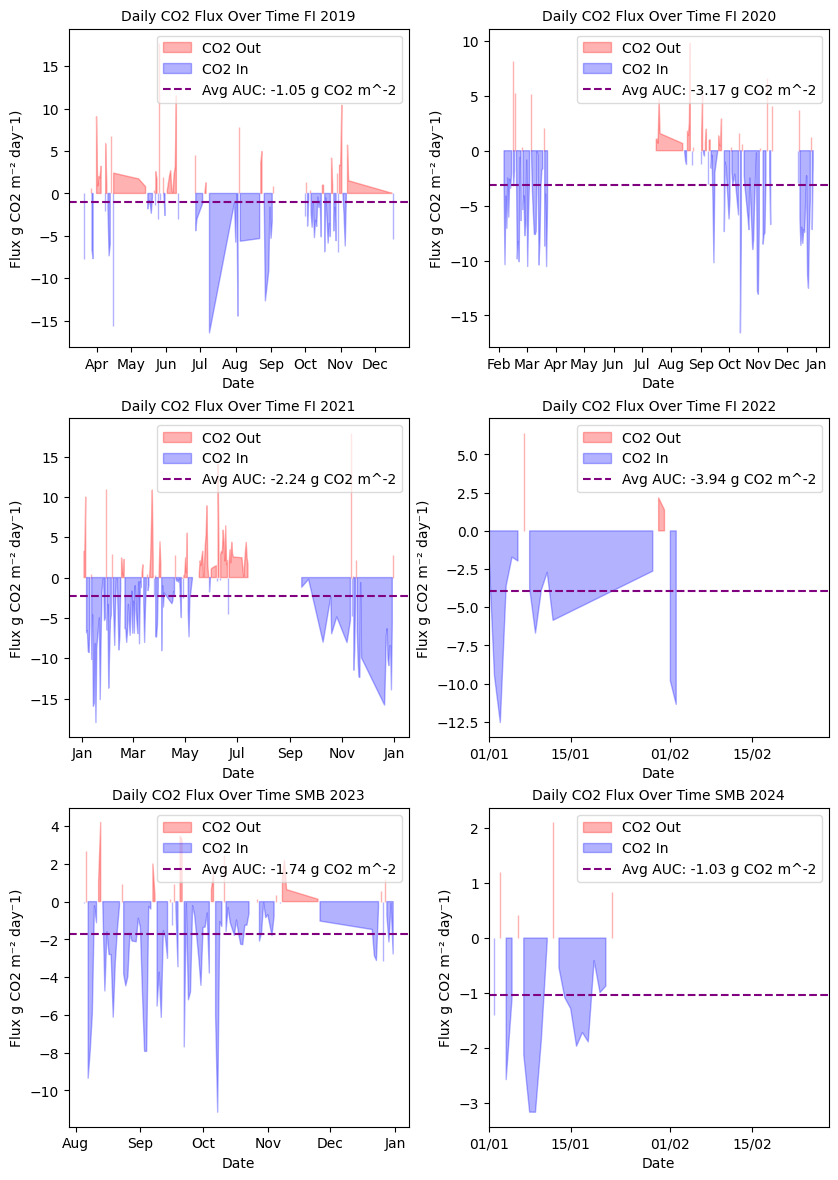

In [4]:


# Set up the figure for a 2x3 grid
fig, axs = plt.subplots(3, 2, figsize=(8.27, 11.69/2*2), constrained_layout=True)
axs = axs.flatten()

# Custom date ranges for specific years to show day and month
custom_date_ranges = {
    2024: (pd.to_datetime('2024-01-01'), pd.to_datetime('2024-02-28')), # For SMB 2024
    2022: (pd.to_datetime('2022-01-01'), pd.to_datetime('2022-02-28'))  # For FI 2022
}

# Font size configuration
font_size = 10  # Adjust as needed

# Process SMB and FI datasets
calc_auc('FI_filtered_data_1_STD.csv', 'FI', axs, 0, custom_date_ranges, font_size=font_size)
calc_auc('SMB_filtered_data_1_STD.csv', 'SMB', axs, 4, custom_date_ranges, font_size=font_size) # start_idx is 3 for SMB to plot it in the second half of the grid

plt.show()


### Plot Gaussian

Error in processing FI: name 'gaussian' is not defined
Error in processing SMB: name 'gaussian' is not defined


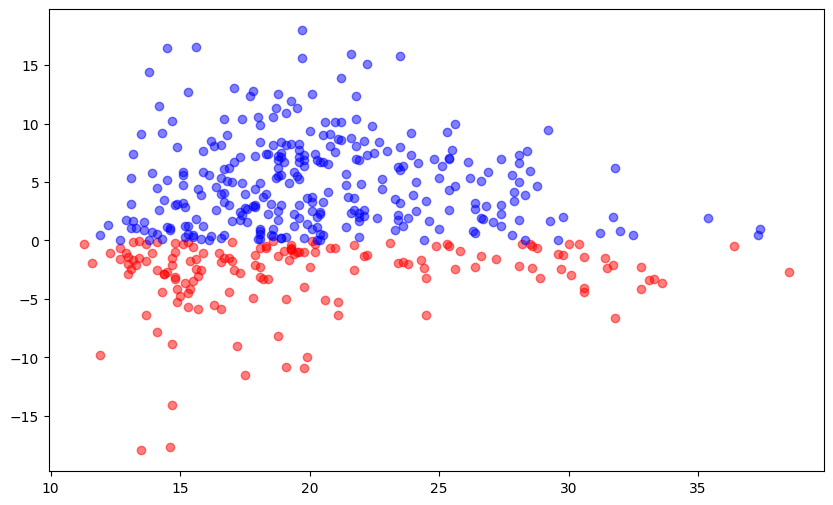

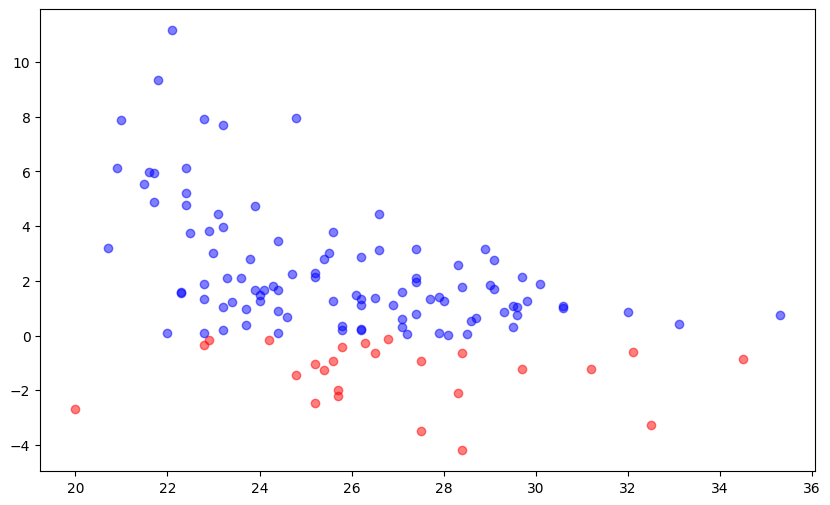

In [5]:
# Guassian Fit Plots

gaussian_fit_daily_flux_and_temp('FI', 'FI_merged_AUC_and_temperature.csv')
gaussian_fit_daily_flux_and_temp('SMB', 'SMB_merged_AUC_and_temperature.csv')
